In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from prophet import Prophet
from scipy.fftpack import fft

00:49:28 - cmdstanpy - INFO - Chain [1] start processing
00:49:28 - cmdstanpy - INFO - Chain [1] done processing


Columns in dataset: Index(['pickup_datetime', 'pickup_location_id'], dtype='object')
Optimized Prophet Model with FFT-PCA Features MAE: 46.4931
Forecasted Values:
                     ds       yhat  yhat_lower  yhat_upper
744 2023-02-01 00:00:00  43.898511  -31.625507  121.684786
745 2023-02-01 01:00:00  34.381423  -41.362768  109.490964
746 2023-02-01 02:00:00  50.215175  -23.543457  126.730161
747 2023-02-01 03:00:00  77.255470   -0.175445  157.592025
748 2023-02-01 04:00:00  84.423515    4.568828  161.963898
749 2023-02-01 05:00:00  55.128515  -22.351616  132.454159
750 2023-02-01 06:00:00   7.565680  -70.675605   80.140610
751 2023-02-01 07:00:00 -18.070308  -96.296011   56.362832
752 2023-02-01 08:00:00   4.524272  -71.366979   80.871311
753 2023-02-01 09:00:00  62.252839  -18.778443  140.270188


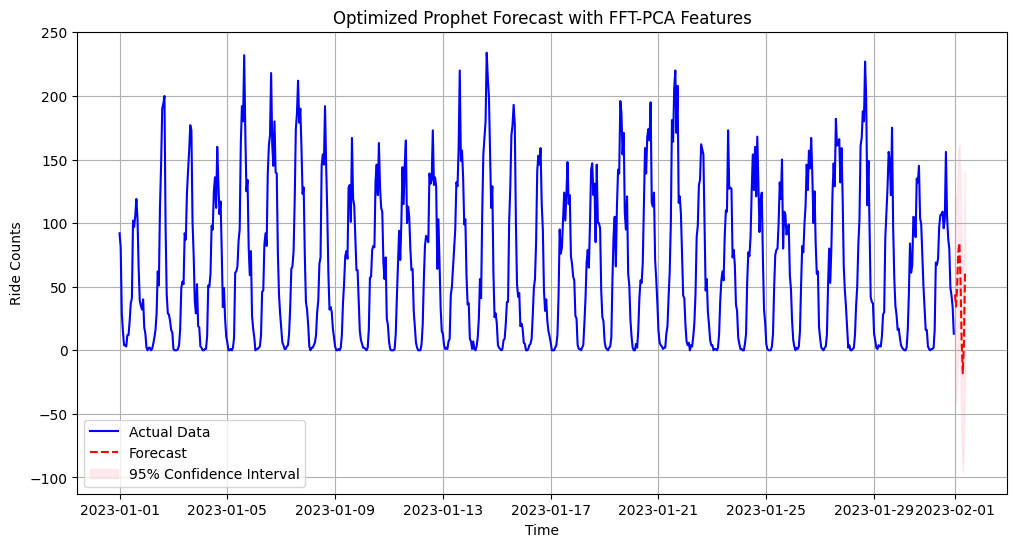

In [27]:
# Load time series data from a Parquet file
def load_data(parquet_path):
    """Loads time series data from a Parquet file."""
    df = pd.read_parquet(parquet_path, engine='pyarrow')
    print("Columns in dataset:", df.columns)  # Debugging: Print available columns
    return df

# Preprocess data
def preprocess_data(df, location_id=43):
    """Filters data for a specific location and ensures a time series format."""
    if "pickup_datetime" not in df.columns:
        raise KeyError("Column 'pickup_datetime' not found in dataset. Available columns: " + str(df.columns))
    
    df["pickup_hour"] = pd.to_datetime(df["pickup_datetime"]).dt.floor("h")  # Convert datetime to hourly
    df = df[df["pickup_location_id"] == location_id]
    df = df.sort_values("pickup_hour")
    df = df.set_index("pickup_hour")
    
    # Use only the last 6 months of data to improve recent trends
    six_months_ago = df.index.max() - pd.DateOffset(months=6)
    df = df[df.index >= six_months_ago]
    
    # Resample to ensure all hourly timestamps are present, filling missing values with 0
    ts_data = df["pickup_location_id"].resample("H").count().reset_index()
    ts_data.columns = ["ds", "y"]  # Prophet requires columns named 'ds' and 'y'
    
    return ts_data

# Generate FFT-based features efficiently
def generate_fft_features(ts_data, variance_threshold=0.95):
    """Computes FFT and extracts top frequency components based on variance threshold."""
    y_fft = fft(ts_data["y"])
    freqs = np.fft.fftfreq(len(ts_data))
    df_fft = pd.DataFrame({"frequency": freqs, "amplitude": np.abs(y_fft)})
    
    # Select frequencies that contribute to 95% variance
    df_fft = df_fft.sort_values(by="amplitude", ascending=False)
    total_variance = df_fft["amplitude"].sum()
    df_fft["cumulative_variance"] = df_fft["amplitude"].cumsum() / total_variance
    df_fft = df_fft[df_fft["cumulative_variance"] <= variance_threshold]
    
    # Efficiently create FFT feature matrix
    fft_features = np.array([np.sin(2 * np.pi * row["frequency"] * np.arange(len(ts_data))) * row["amplitude"] for _, row in df_fft.iterrows()]).T
    fft_feature_cols = [f"fft_{i}" for i in range(fft_features.shape[1])]
    fft_df = pd.DataFrame(fft_features, columns=fft_feature_cols)
    
    # Concatenate efficiently to avoid fragmentation
    ts_data = pd.concat([ts_data, fft_df], axis=1)
    return ts_data

# Apply PCA for feature selection
def apply_pca(ts_data, n_components=5):
    """Reduces the dimensionality of FFT features using PCA."""
    feature_cols = [col for col in ts_data.columns if col.startswith("fft_")]
    if len(feature_cols) > 0:
        scaler = StandardScaler()
        pca = PCA(n_components=min(n_components, len(feature_cols)))
        transformed_features = pca.fit_transform(scaler.fit_transform(ts_data[feature_cols]))
        
        for i in range(transformed_features.shape[1]):
            ts_data[f"pca_fft_{i}"] = transformed_features[:, i]
        
        ts_data.drop(columns=feature_cols, inplace=True)  # Remove raw FFT features
    
    return ts_data

# Fit Prophet model
def fit_prophet_model(ts_data):
    """Fits a Prophet model to the time series data including FFT-PCA features."""
    model = Prophet(changepoint_prior_scale=0.05, yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=True)
    for col in ts_data.columns:
        if col.startswith("pca_fft_"):
            model.add_regressor(col)
    model.fit(ts_data)
    return model

# Forecast future values
def forecast_prophet_model(model, ts_data, steps=10):
    """Generates forecasts using the fitted Prophet model."""
    future = model.make_future_dataframe(periods=steps, freq='H')
    for col in ts_data.columns:
        if col.startswith("pca_fft_"):
            future[col] = ts_data[col].mean()
    forecast = model.predict(future)
    return forecast.tail(steps)[["ds", "yhat", "yhat_lower", "yhat_upper"]]

# Calculate MAE
def calculate_mae(actual, forecasted):
    """Calculates the Mean Absolute Error (MAE) between actual and forecasted values."""
    return mean_absolute_error(actual, forecasted)

# Plot actual and forecasted values
def plot_forecast(ts_data, forecast):
    """Plots actual data and forecasted values with confidence intervals."""
    plt.figure(figsize=(12, 6))
    plt.plot(ts_data["ds"], ts_data["y"], label="Actual Data", color='blue')
    plt.plot(forecast["ds"], forecast["yhat"], label="Forecast", linestyle='dashed', color='red')
    plt.fill_between(forecast["ds"], forecast["yhat_lower"], forecast["yhat_upper"], color='pink', alpha=0.3, label="95% Confidence Interval")
    plt.xlabel("Time")
    plt.ylabel("Ride Counts")
    plt.title("Optimized Prophet Forecast with FFT-PCA Features")
    plt.legend()
    plt.grid()
    plt.show()

if __name__ == "__main__":
    # Define file path
    parquet_file_path = "/Users/sree/Documents/CDA/Project_1/sp25_taxi-main/data/processed"  # Update with actual path
    
    # Load and preprocess data
    try:
        ts_df = load_data(parquet_file_path)
        ts_series = preprocess_data(ts_df)
        ts_series = generate_fft_features(ts_series)  # Extract FFT-based features efficiently
        ts_series = apply_pca(ts_series)  # Apply PCA for better feature selection
    
        # Fit Prophet model
        prophet_model = fit_prophet_model(ts_series)
    
        # Forecast the next 10 time steps
        forecast_values = forecast_prophet_model(prophet_model, ts_series, steps=10)
    
        # Calculate and print MAE
        mae = calculate_mae(ts_series["y"].tail(10), forecast_values["yhat"])
        print(f"Optimized Prophet Model with FFT-PCA Features MAE: {mae:.4f}")
    
        # Print forecasts
        print("Forecasted Values:")
        print(forecast_values)
    
        # Plot actual vs forecasted values
        plot_forecast(ts_series, forecast_values)
    
    except Exception as e:
        print(f"Error: {e}")